In [1]:
# imports and configuration

# uncomment to use a custom environment file
# from dotenv import load_dotenv
# load_dotenv('../main.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR

import torchvision.transforms.v2 as transforms
from torchvision.datasets import CIFAR10

from introdl.utils import get_device, load_results, summarizer, create_CIFAR10_loaders
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


# Advanced Neural Network Design

Our simple CNN on CIFAR-10 maxed out around 78% accuracy on the validation data, but this result shows that there's room to improve by capturing more complex patterns in the data. As tasks become more challenging—like recognizing subtle image details or intricate patterns—simple models often can’t reach high accuracy. They don’t have the capacity to learn advanced features or abstractions needed to handle the full complexity of the data.

Making networks deeper rather than wider helps tackle this. With more layers, a network can build on the features learned in previous layers to recognize higher-level concepts. For example, in an image, early layers might detect edges, while deeper layers recognize shapes or specific objects. Wider networks, on the other hand, add parameters but usually capture only limited higher-level representations. They lack the sequential refinement that deeper networks achieve, which allows each layer to improve on the previous one.

As we make networks deeper, however, they become harder to train effectively. To address this, we use modern techniques like batch normalization and residual connections. These methods help manage issues that arise with depth, such as vanishing gradients, allowing deep networks to learn complex patterns more reliably and efficiently.

In this notebook we'll start with a deeper network applied to CIFAR-10 and progressively add batch normalization and residual connections to make it easier to train.  

## Using Repeating Blocks and Layers

CNNs often use **repeating blocks and layers** to help the network gradually learn complex patterns from simple to abstract, while keeping the model structure organized and efficient. Here’s a breakdown of why this approach is effective:

1. **Hierarchical Feature Learning**:
   - Early layers in the network learn basic features like edges and textures.
   - As you stack more layers, each one builds on the previous, learning increasingly complex patterns like shapes, and eventually, full objects.
   - Repeating blocks help the network capture this hierarchy of features across many levels.

2. **Increased Depth Without Complexity**:
   - Instead of creating a unique setup for each layer, repeating blocks allow us to use the same small structure multiple times, simplifying the design while still making the network deeper.
   - This depth is essential for learning more abstract and nuanced features, which improves the model’s ability to understand complex patterns.

3. **Efficiency and Reusability**:
   - Using repeated blocks makes the network easier to design and adjust, as you can reuse the same structure without adding unnecessary complexity.
   - It also helps with computational efficiency and keeps the model structure manageable, as the same operations are applied across different stages.

4. **Consistency in Pattern Extraction**:
   - Repeating layers help the model consistently extract similar types of information across the image. For instance, each block might look for edges, colors, or shapes in different parts of the image.
   - This repetition strengthens the network’s ability to recognize these patterns anywhere in the image, making the model more robust to variations in the input.

Now we'll show how to use this strategy to build a deeper CNN that we'll then apply to CIFAR-10 classification.

### PlainDeepCNN

We'll show how to build the `PlainDeepCNN` architecture in a hierarchical way using "blocks" and "layers".  Ultimately our model will have 16 convolutional layers followed by ReLU activation functions plus a few more layers.  

#### Step 1: Setup a Block
In a deep CNN, it’s common to have multiple convolutional layers working together. To simplify our model's organization, we group two convolutional layers into a "block." Each block will:
1. Apply a convolution to the input.
2. Use a ReLU activation function to add non-linearity.
3. Apply another convolution and ReLU.

Think of each block as a "mini-CNN" that extracts features at a given depth.

Here’s the code for our `SimpleBlock`:

```python
class SimpleBlock(nn.Module):
    """A block with two convolutional layers."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(SimpleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
```



Each `SimpleBlock` is set up to use **two convolutional layers** and apply a ReLU activation function after each.

#### Step 2: Build Layers from Blocks
In our main model, we want to deepen the network, adding layers that process the image at different resolutions. Each of these layers will be created using multiple `SimpleBlock` instances.

The `PlainDeepCNN` class uses a `_make_layer` method to construct a layer with a specified number of `SimpleBlock` blocks, and it repeats this process for four layers, increasing the channels at each stage (16, 32, 64, and 128).

```python
def _make_layer(self, out_channels, blocks, stride):
    layers = []
    layers.append(SimpleBlock(self.in_channels, out_channels, stride))
    self.in_channels = out_channels
    for _ in range(1, blocks):
        layers.append(SimpleBlock(out_channels, out_channels))
    return nn.Sequential(*layers)
```



In this function:
- `out_channels` specifies how many filters each `SimpleBlock` in the layer will have.
- `blocks` defines the number of `SimpleBlock` blocks in the layer.
- `stride` controls downsampling for the first block in each layer, reducing the spatial dimensions of the feature maps.

#### Step 3: Putting It All Together
The `PlainDeepCNN` model uses four main layers, each generated by `_make_layer`, and adds a fully connected layer at the end to output class predictions.

Here’s the whole model class.  We also include the earlier code for convenience:

In [2]:
class SimpleBlock(nn.Module):
    """A block with two convolutional layers."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(SimpleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class PlainDeepCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(PlainDeepCNN, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1)
        
        # Four layers with increasing depth
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.layer4 = self._make_layer(128, 2, stride=2)
        
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, x.size(3))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(SimpleBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(SimpleBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

Now we'll create an instance of the model and view it to see the overall structure.

In [3]:
model = PlainDeepCNN()
model

PlainDeepCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): SimpleBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): SimpleBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer2): Sequential(
    (0): SimpleBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): SimpleBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer3): Sequential(
    (0): SimpleBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3)

Let's also look at a summary from torchinfo to see how the resolution of the input images change as they move through the network and to see how many parameters our model has.

In [4]:
summarizer( model, input_size = (1,3,32,32) ) # using a batch size of 1 CIFAR-10 image

Layer (type (var_name))                  Input Shape          Output Shape         Param #
PlainDeepCNN (PlainDeepCNN)              [1, 3, 32, 32]       [1, 10]              --
├─Conv2d (conv1)                         [1, 3, 32, 32]       [1, 16, 32, 32]      448
├─Sequential (layer1)                    [1, 16, 32, 32]      [1, 16, 32, 32]      --
│    └─SimpleBlock (0)                   [1, 16, 32, 32]      [1, 16, 32, 32]      --
│    │    └─Conv2d (conv1)               [1, 16, 32, 32]      [1, 16, 32, 32]      2,320
│    │    └─Conv2d (conv2)               [1, 16, 32, 32]      [1, 16, 32, 32]      2,320
│    └─SimpleBlock (1)                   [1, 16, 32, 32]      [1, 16, 32, 32]      --
│    │    └─Conv2d (conv1)               [1, 16, 32, 32]      [1, 16, 32, 32]      2,320
│    │    └─Conv2d (conv2)               [1, 16, 32, 32]      [1, 16, 32, 32]      2,320
├─Sequential (layer2)                    [1, 16, 32, 32]      [1, 32, 16, 16]      --
│    └─SimpleBlock (0)              

Now let's see if the increased complexity pays off by training the model to classify the CIFAR-10 images. We'll reuse the code from Lesson 3 to get our DataLoaders for CIFAR10.

In [5]:
train_loader, valid_loader, _ = create_CIFAR10_loaders(data_dir=DATA_PATH, 
                                                       use_augmentation=True, 
                                                       num_workers=8)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


The code to train this model is below.  The depth of the network makes it difficult to train.  Here are some things we tried:
* One_cycle training with 20 epochs and max_lr = 0.01.  The network didn't learn.
* No scheduler and 20 epochs with `lr=0.001` again failed to learn.  It seems like the learning rate is too high.
* Reduced the learning rate to `lr=0.0001` and trained for 40 epochs.  Resumed training for another 40 epochs.  The results are below, but it's still not entirely converged.   

In [6]:
model = PlainDeepCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=0.0001)

epochs = 40

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L04_CIFAR10_PlainDeepCNN.pt'

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    resume_checkpoint = True);

cuda


Epoch: 100%|██████████| 40/40 [04:42<00:00,  7.06s/it, train_loss=0.525, val_loss=0.612]


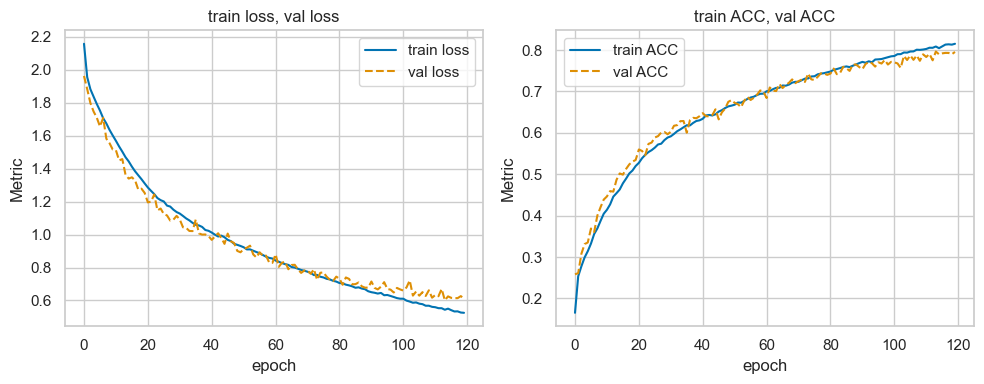

In [7]:
results = load_results(MODELS_PATH / 'L04_CIFAR10_PlainDeepCNN.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

This deeper network is slower to train in terms of epochs than SimpleCNN in the last lesson.  It hasn't yet plateaued, but let's see if we can improve convergence and performance another way.

### DeepCNNwBN

Now we'll add batch normalization after each convolutional layer.  This should speed up training and improve performance.  If you didn't already, you should read about Batch Normalization in Inside Deep Learning.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleBlockBN(nn.Module):
    """A block with two convolutional layers and batch normalization."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(SimpleBlockBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after conv2

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Apply batch normalization and ReLU after conv1
        x = F.relu(self.bn2(self.conv2(x)))  # Apply batch normalization and ReLU after conv2
        return x

class DeepCNNwBN(nn.Module):
    """A deeper CNN with batch normalization for CIFAR-10."""
    def __init__(self, num_classes=10):
        super(DeepCNNwBN, self).__init__()
        self.in_channels = 16

        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.in_channels)  # Batch normalization after initial conv
        
        # Four layers with increasing depth
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.layer4 = self._make_layer(128, 2, stride=2)
        
        # Classifier
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(SimpleBlockBN(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(SimpleBlockBN(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Batch normalization and ReLU after initial conv
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global average pooling and flattening
        x = F.avg_pool2d(x, x.size(3))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

First, we'll train for 10 epochs with a learning rate of 0.001 to see if it works.  Recall, that the network without batch normalization would not learn.

In [9]:
model = DeepCNNwBN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

epochs = 10

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L04_CIFAR10_DeepCNNwBN.pt'

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file);

cuda


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [01:16<00:00,  7.67s/it, train_loss=0.638, val_loss=0.638]


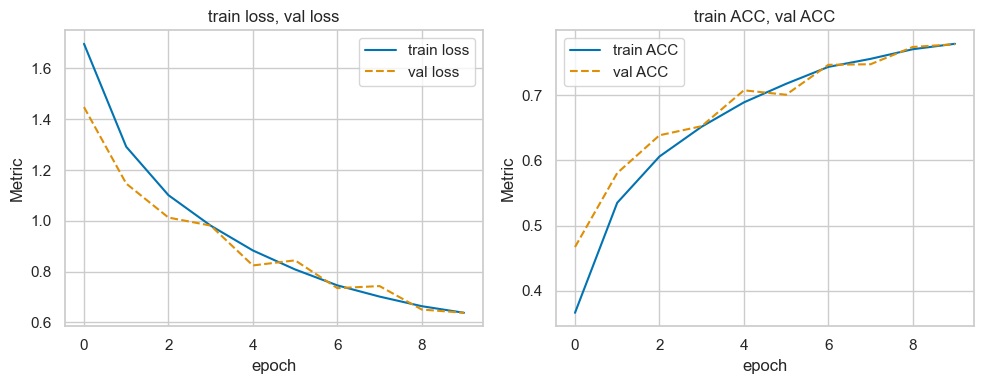

In [10]:
results = load_results(MODELS_PATH / 'L04_CIFAR10_DeepCNNwBN.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

Our model is training well.  We could just resume and train for longer, but batch normalization stabilizes training so well that it's often possible to train more aggressively.  Here we'll try a 1cycle policy with a max learning rate of 0.01 for 20 epochs.

In [11]:
model = DeepCNNwBN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

epochs = 20
max_lr = 0.01
scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L04_CIFAR10_DeepCNNwBN_one_cycle.pt'

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    lr_schedule = scheduler,
    scheduler_step_per_batch=True);

cuda


Epoch: 100%|██████████| 20/20 [02:26<00:00,  7.32s/it, train_loss=0.314, val_loss=0.404]


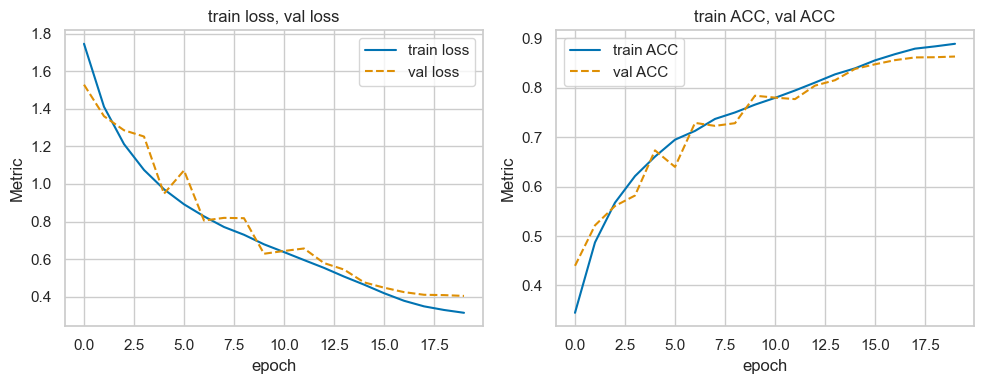

In [12]:
results = load_results(MODELS_PATH / 'L04_CIFAR10_DeepCNNwBN_one_cycle.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

Our model is able to achieve around 85% accuracy on the validation data in just 20 epochs.  We did try another 1cycle run with just 10 epochs, but it didn't do as well.

We have one more improvement to make to our network.

### DeepCNNwBNRes

Now we'll add residual connections within each block.  This should allow for easier training and may improve performance.  There are two different versions of the residual connection we'll be adding.  If the convolutional layers don't change the number of channels (increase the number of feature maps) and the feature maps aren't downsampled then the residual connection will look like this:

<img src="./pictures/Residual_Block.drawio.png" alt="Residual Block" style="width: 400px;"/>

However if the number of channels changes or the feature maps are downsampled (by setting stride=2), then our residual block adds a different shortcut connection to that the results of the convolutional blocks and the shortcut are compatible like this:

<img src="./pictures/Residual_Block2.drawio.png" alt="Residual Block 2" style="width: 500px;"/>

In [13]:
class ResidualBlockBN(nn.Module):
    """A residual block with two convolutional layers, batch normalization, and a residual connection."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlockBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut layer to match dimensions if downsampling is needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Main path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add shortcut to main path
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class DeepCNNwBNRes(nn.Module):
    """A deeper CNN with batch normalization and residual connections for CIFAR-10."""
    def __init__(self, num_classes=10):
        super(DeepCNNwBNRes, self).__init__()
        self.in_channels = 16

        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        # Four layers with increasing depth and residual connections
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.layer4 = self._make_layer(128, 2, stride=2)
        
        # Classifier
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlockBN(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlockBN(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global average pooling and flattening
        x = F.avg_pool2d(x, x.size(3))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Let's have a look at our model summary to help understand how the residual blocks are working.

In [19]:
model = DeepCNNwBNRes() # create a new instance of the model
summarizer( model, input_size = (1,3,32,32) ) # using a batch size of 1 CIFAR-10 image

Layer (type (var_name))                  Input Shape          Output Shape         Param #
DeepCNNwBNRes (DeepCNNwBNRes)            [1, 3, 32, 32]       [1, 10]              --
├─Conv2d (conv1)                         [1, 3, 32, 32]       [1, 16, 32, 32]      448
├─BatchNorm2d (bn1)                      [1, 16, 32, 32]      [1, 16, 32, 32]      32
├─Sequential (layer1)                    [1, 16, 32, 32]      [1, 16, 32, 32]      --
│    └─ResidualBlockBN (0)               [1, 16, 32, 32]      [1, 16, 32, 32]      --
│    │    └─Conv2d (conv1)               [1, 16, 32, 32]      [1, 16, 32, 32]      2,320
│    │    └─BatchNorm2d (bn1)            [1, 16, 32, 32]      [1, 16, 32, 32]      32
│    │    └─Conv2d (conv2)               [1, 16, 32, 32]      [1, 16, 32, 32]      2,320
│    │    └─BatchNorm2d (bn2)            [1, 16, 32, 32]      [1, 16, 32, 32]      32
│    │    └─Sequential (shortcut)        [1, 16, 32, 32]      [1, 16, 32, 32]      --
│    └─ResidualBlockBN (1)               [

Now let's train.  Again we'll use the OneCycleLR scheduler with a large learning rate of 0.1.

In [17]:
model = DeepCNNwBNRes() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

epochs = 20
max_lr = 0.01
scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L04_CIFAR10_DeepCNNwBNRes_one_cycle.pt'

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    lr_schedule = scheduler,
    scheduler_step_per_batch=True);

cuda


Epoch: 100%|██████████| 20/20 [02:18<00:00,  6.92s/it, train_loss=0.245, val_loss=0.365]


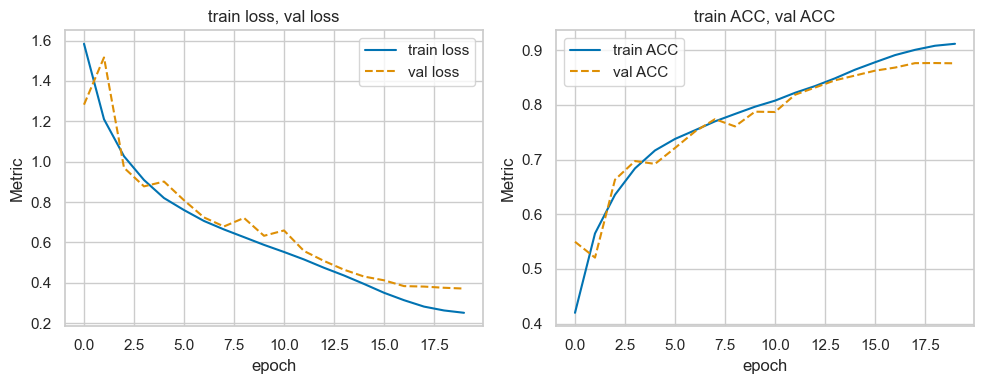

In [15]:
results = load_results(MODELS_PATH / 'L04_CIFAR10_DeepCNNwBNRes_one_cycle.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

Finally, let's compare the validation set performance of DeepCNNBN and DeepCNNBNRes.

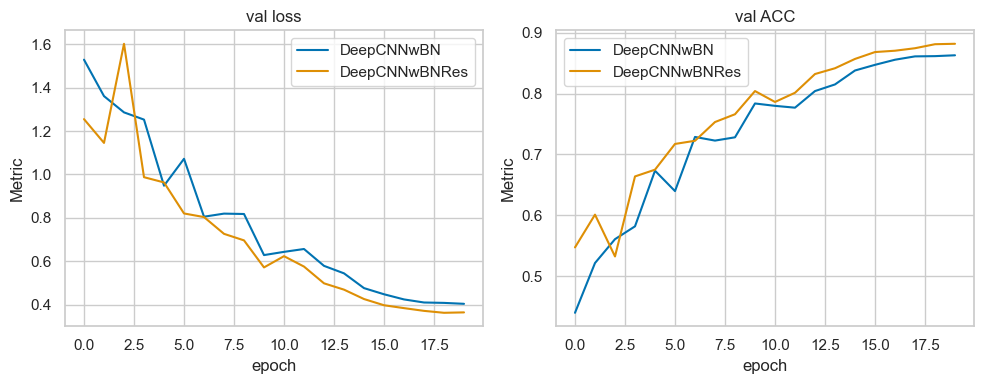

In [18]:
results_BN = load_results(MODELS_PATH / 'L04_CIFAR10_DeepCNNwBN_one_cycle.pt')
results_BNRes = load_results(MODELS_PATH / 'L04_CIFAR10_DeepCNNwBNRes_one_cycle.pt')

plot_training_metrics([results_BN,results_BNRes], [['val loss'], ['val ACC']],df_labels=['DeepCNNwBN','DeepCNNwBNRes'])

We can see that the combination of batch normalization and residual connections improves model performance over batch normalization alone.

Most modern CNNs combine both of these techniques.  You may have noted that our model didn't include any pooling layers.  Instead we used stride = 2 to reduce the resolution of the feature maps for simplicity. 

In larger, deeper networks strided convolutions are often combined with max pooling to reduce the resolution of the features.  In the popular ResNet family of networks max pooling is used at the beginning of the network to quickly reduce the dimensions of the feature maps while stride=2 convolutions are used throughout the network to further reduces the spatial dimensions.  Finally, at the end of the network ResNet uses global average pooling to average each feature map to a single value in each channel.

If you want to learn more give this prompt to an AI: "does the resnet family of models use strided convolutions or pooling or both to reduce feature dimensions?"